## Import data

In [5]:
import os
import glob

# copy files from Google Drive
for part in glob.glob("/content/drive/MyDrive/cholec/cholec10*"):
    cmd = f"cp -i {part} /content"
    os.system(cmd)

In [7]:
# upzip and remove the copied files
for part in glob.glob("/content/cholec10*"):
    unzip_cmd = f"unzip {part} -d /content"
    rm_cmd = f"rm {part}"
    os.system(unzip_cmd)
    os.system(rm_cmd)

In [ ]:
!ls /content/data/video01/

In [ ]:
%matplotlib inline

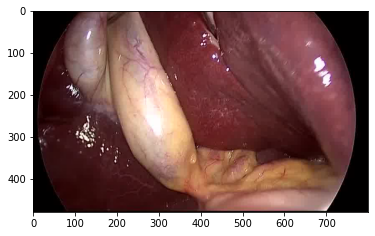

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/data/video01/image_00075.jpg')
plt.imshow(img)

In [ ]:
img.shape

(480, 800, 3)

In [ ]:
import pandas as pd

data = pd.read_csv("/content/tool_annotations/video01-tool.txt", sep='\t')
data

,Frame,Grasper,Bipolar,Hook,Scissors,Clipper,Irrigator,SpecimenBag
0,0,1,0,0,0,0,0,0
1,25,1,0,0,0,0,0,0
2,50,1,0,0,0,0,0,0
3,75,1,0,0,0,0,0,0
4,100,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1728,43200,0,0,0,0,0,0,0
1729,43225,0,0,0,0,0,0,0
1730,43250,0,0,0,0,0,0,0
1731,43275,0,0,0,0,0,0,0


## Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e385e0710>,
      dtype=object)

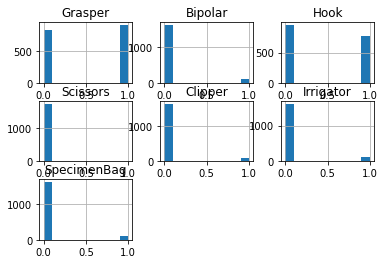

In [ ]:
tools = ['Grasper', 'Bipolar', 'Hook', 'Scissors', 'Clipper', 'Irrigator', 'SpecimenBag']
data[tools].hist()

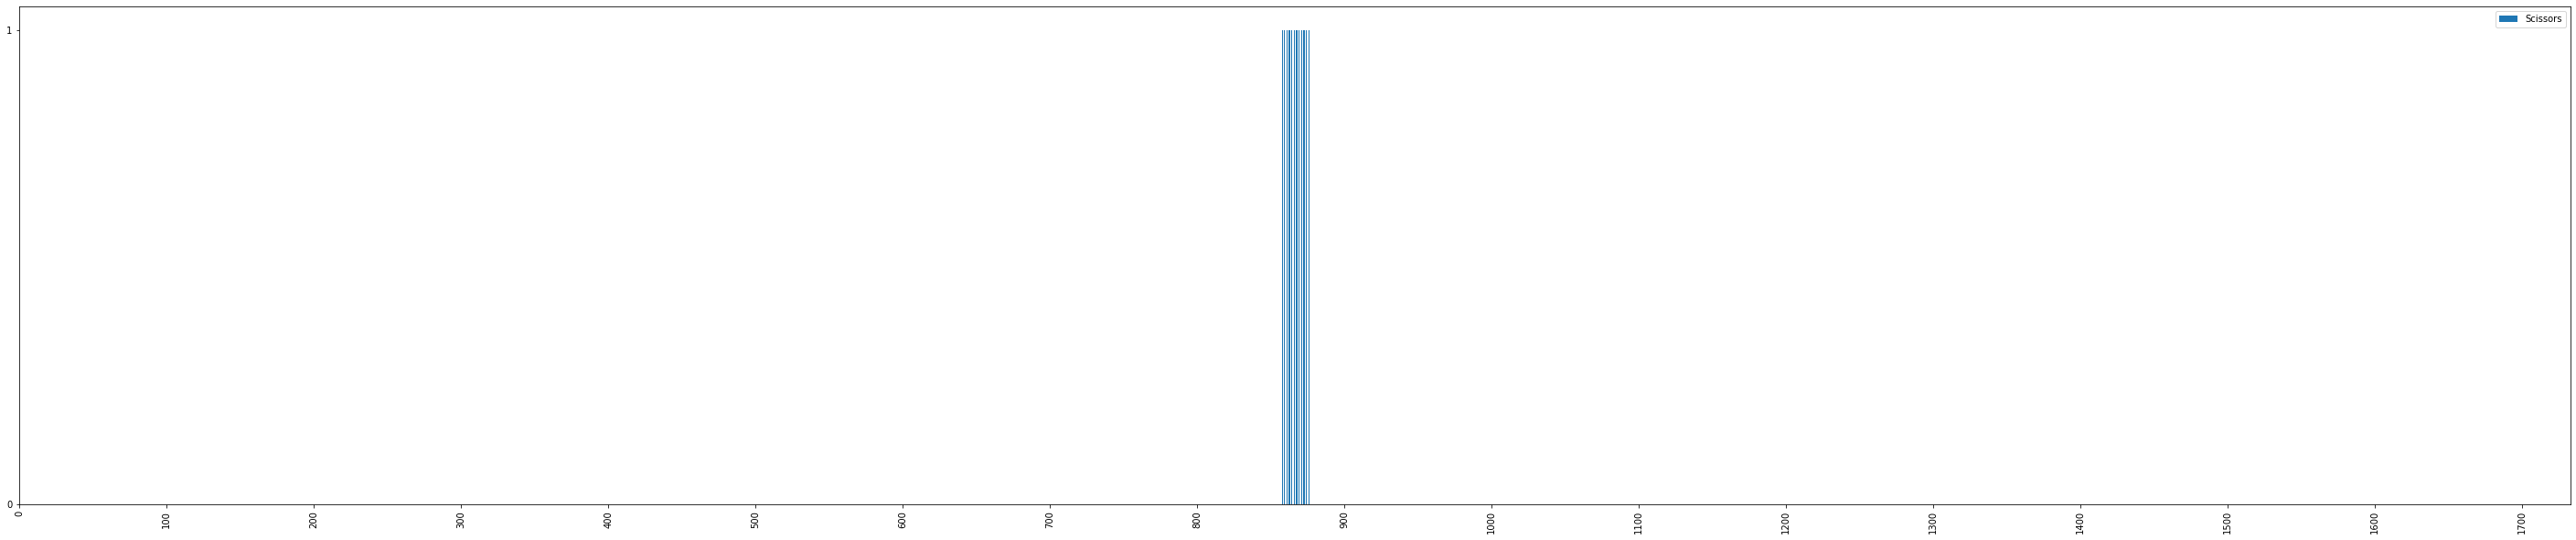

In [ ]:
data[['Frame', 'Scissors']].plot.bar(y='Scissors', figsize=(50, 10), xticks=list(range(0, 1800, 100)), yticks=[0, 1])

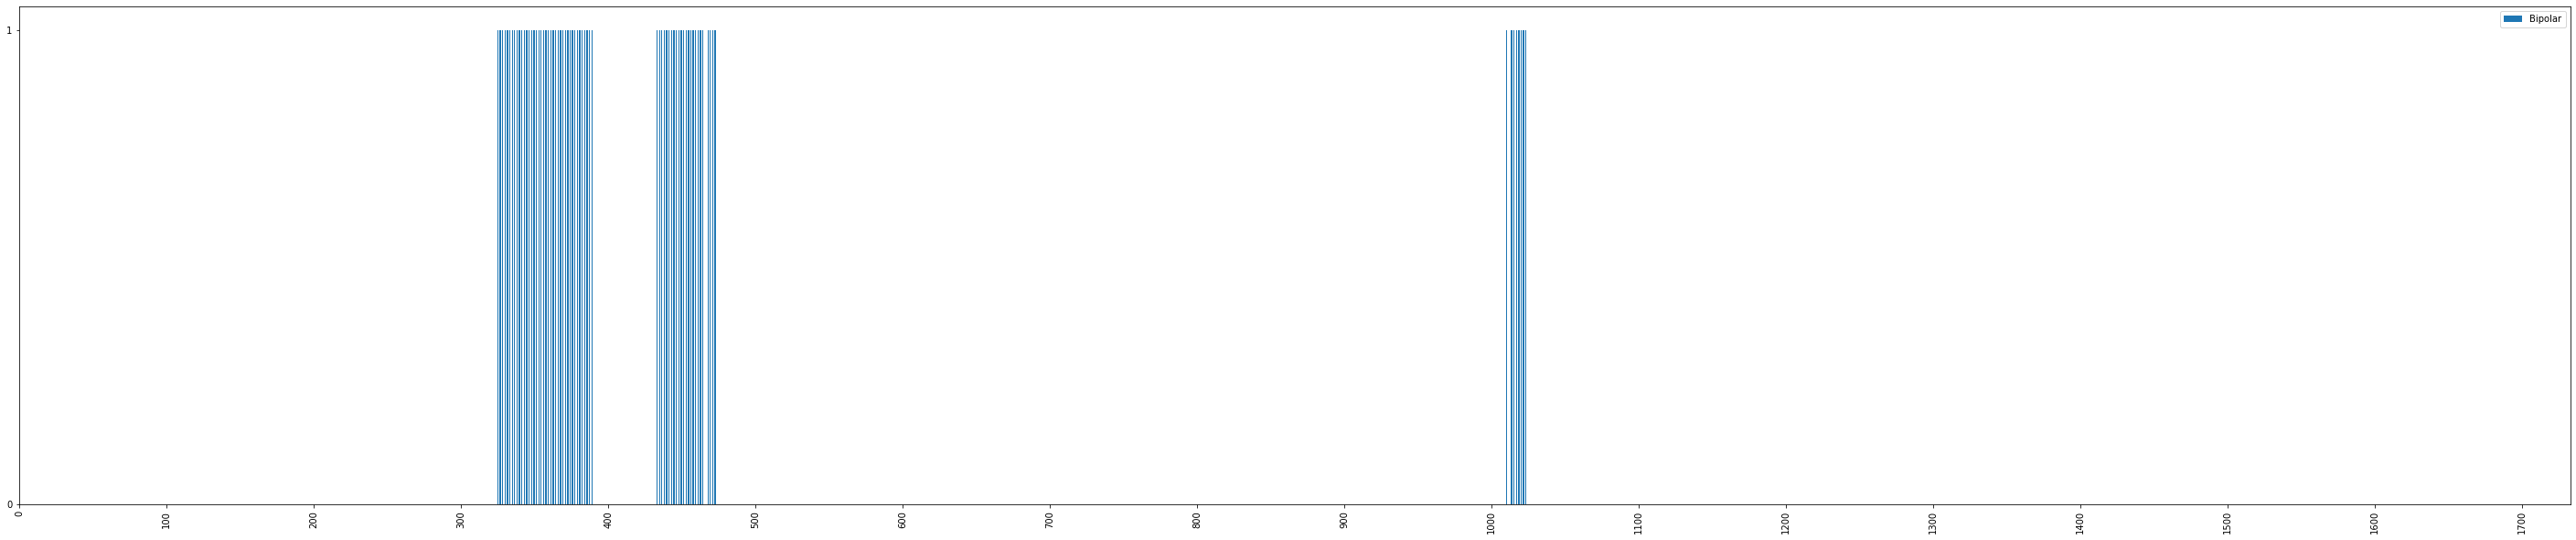

In [ ]:
data[['Frame', 'Bipolar']].plot.bar(y='Bipolar', figsize=(50, 10), xticks=list(range(0, 1800, 100)), yticks=[0, 1])

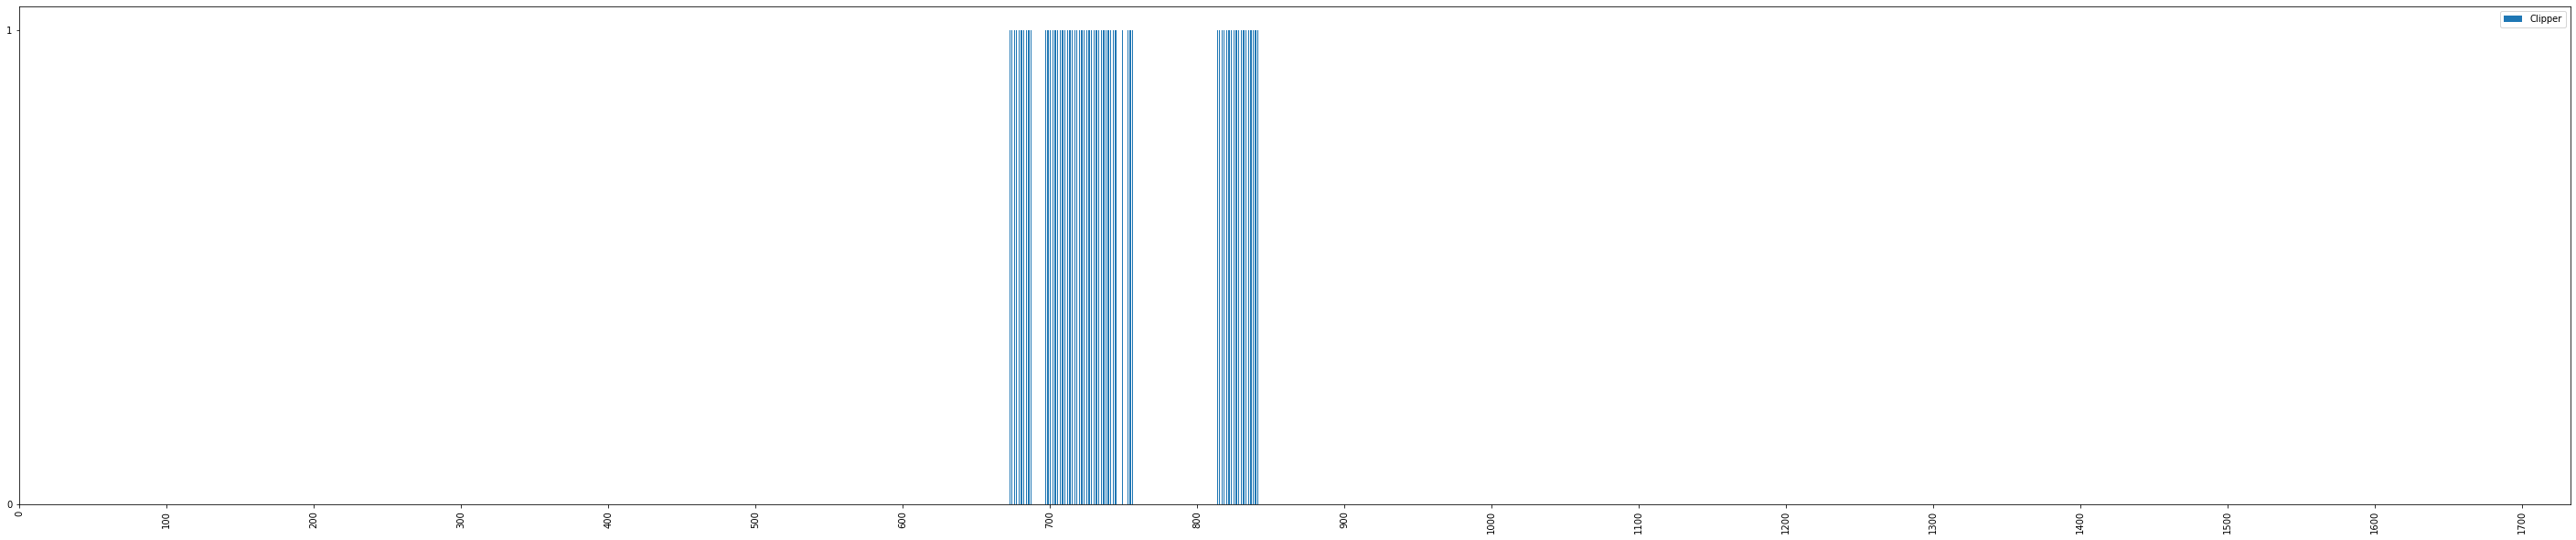

In [ ]:
data[['Frame', 'Clipper']].plot.bar(y='Clipper', figsize=(50, 10), xticks=list(range(0, 1800, 100)), yticks=[0, 1])

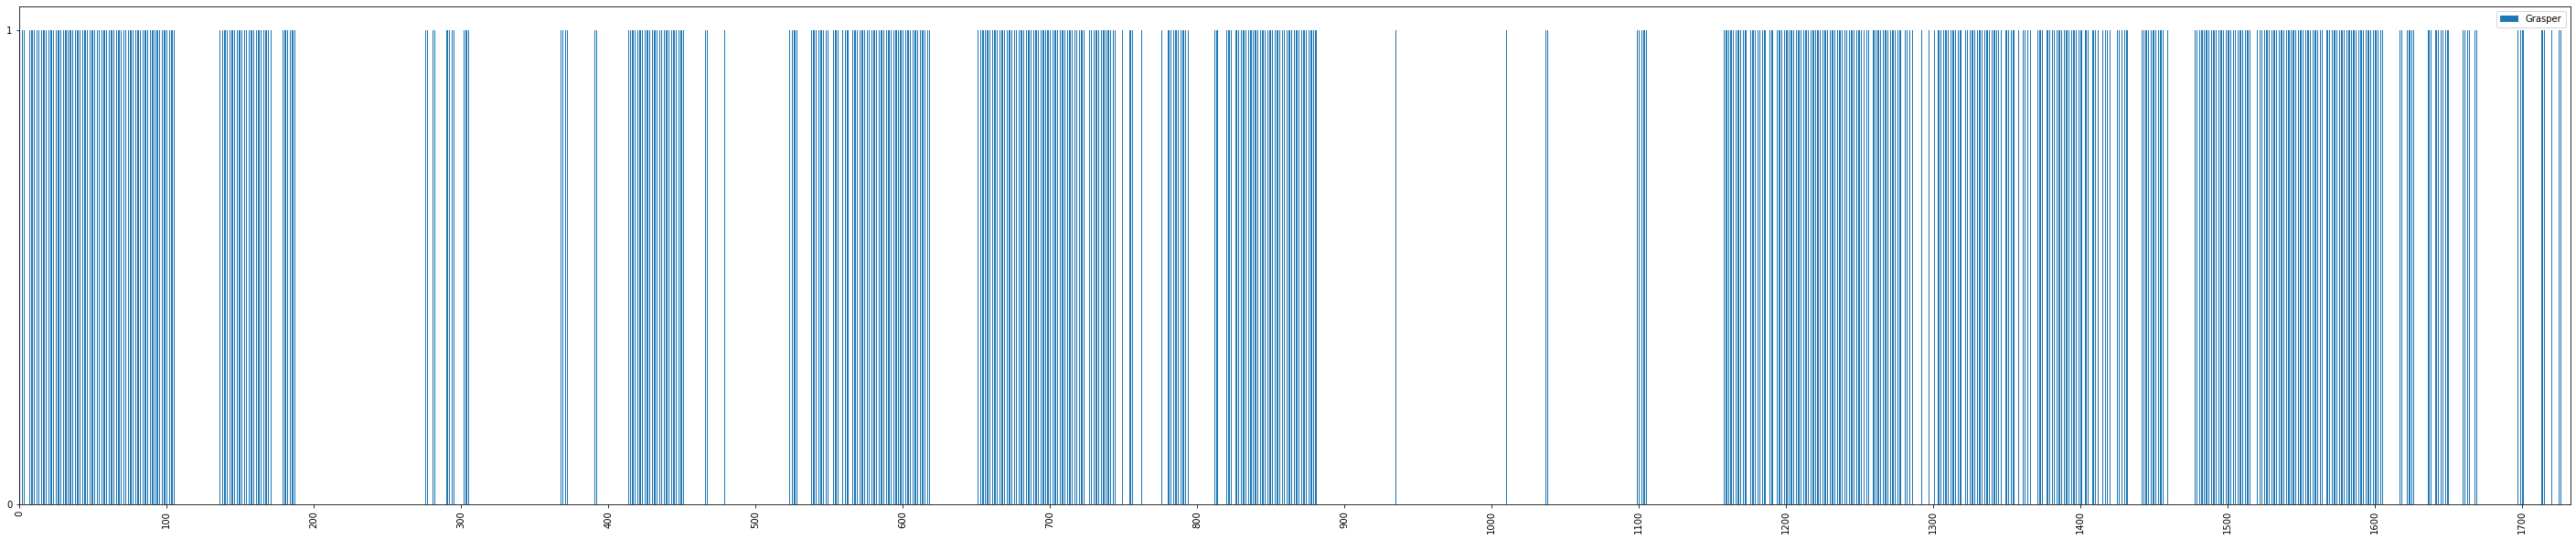

In [ ]:
data[['Frame', 'Grasper']].plot.bar(y='Grasper', figsize=(50, 10), xticks=list(range(0, 1800, 100)), yticks=[0, 1])

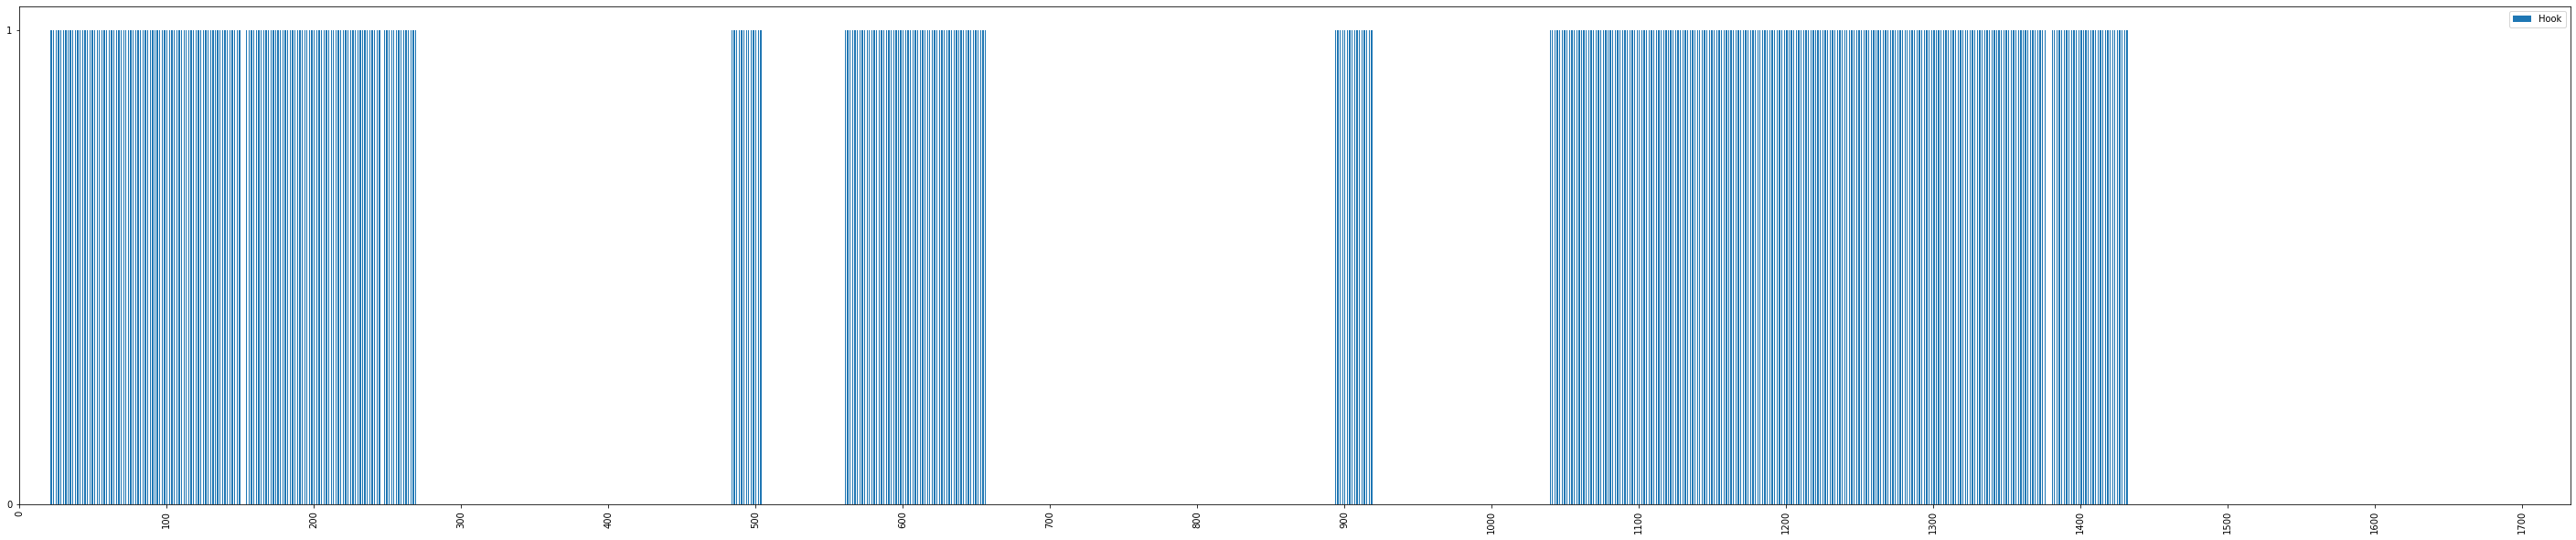

In [ ]:
data[['Frame', 'Hook']].plot.bar(y='Hook', figsize=(50, 10), xticks=list(range(0, 1800, 100)), yticks=[0, 1])

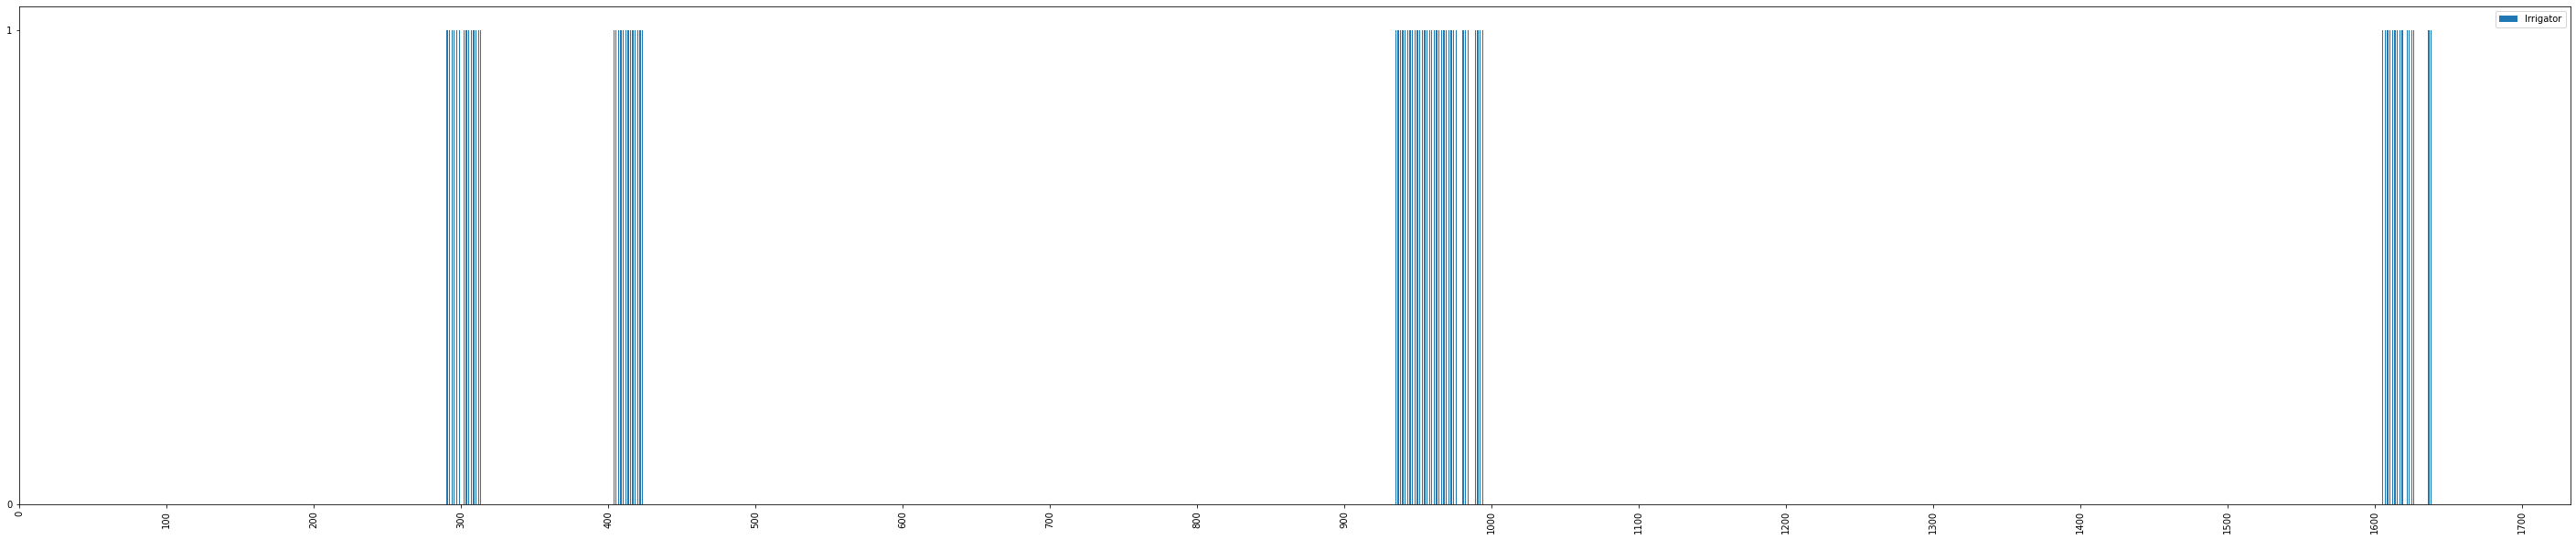

In [ ]:
data[['Frame', 'Irrigator']].plot.bar(y='Irrigator', figsize=(50, 10), xticks=list(range(0, 1800, 100)), yticks=[0, 1])

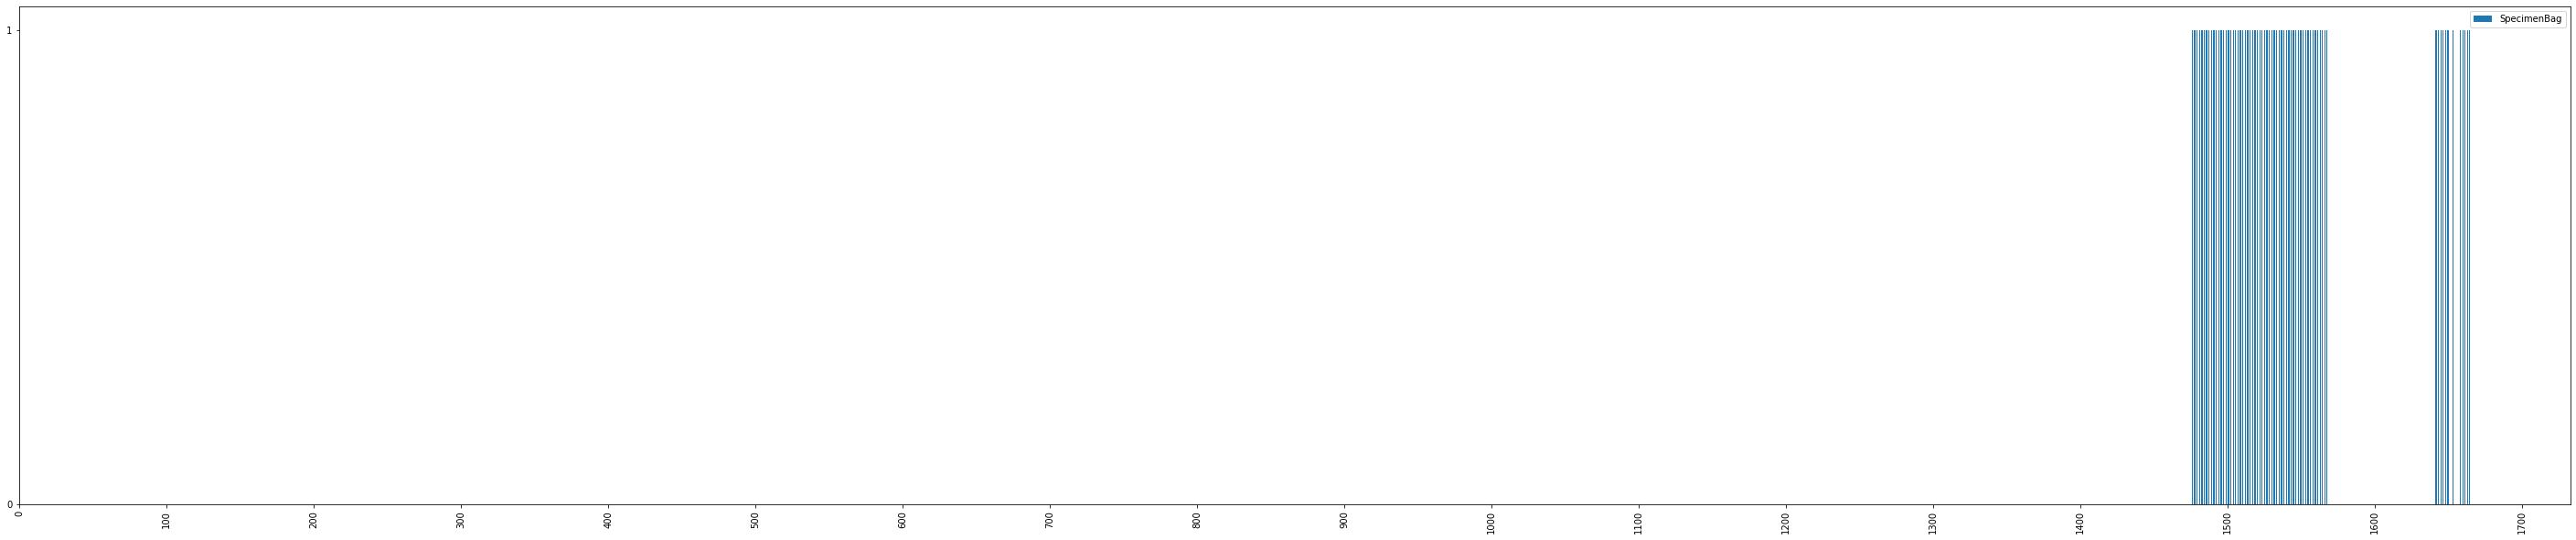

In [ ]:
data[['Frame', 'SpecimenBag']].plot.bar(y='SpecimenBag', figsize=(50, 10), xticks=list(range(0, 1800, 100)), yticks=[0, 1])

## Data preparation

In [8]:
# Config
import os

BASE_PATH = "/content"
ANNOT_PATH = os.path.sep.join([BASE_PATH, "tool_annotations"])
DATA_PATH = os.path.sep.join([BASE_PATH, "data"])
RECORDS_PATH = "/content/drive/MyDrive/cholec/records"

In [9]:
import tensorflow as tf

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _int64_list_feature(value):
    """Returns an int64_list from bool / enum / int / uint list."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

class TFAnnotation:
	def __init__(self):
		# initialize the label lists
		self.labels = []

		# initialize additional variables, including the the image
		# itself, spatial dimensions, encoding, and filename
		self.image = None
		self.width = None
		self.height = None
		self.encoding = None
		self.filename = None

	def build(self):
		# encode the attributes using their respective TensorFlow
		# encoding function
		w = _int64_feature(self.width)
		h = _int64_feature(self.height)
		filename = _bytes_feature(self.filename.encode("utf8"))
		encoding = _bytes_feature(self.encoding.encode("utf8"))
		image = _bytes_feature(self.image)
		labels = _int64_list_feature(self.labels)

		# construct the TensorFlow-compatible data dictionary
		data = {
			"height": h,
			"width": w,
			"filename": filename,
			"image": image,
			"format": encoding,
			"labels": labels,
		}

		# return the data dictionary
		return data

In [10]:
import numpy as np
import os
from PIL import Image

encoding = "jpg"
def generate_record(dataPath, annotPath, outputPath):
    # open the annotation file to read data
    with open(annotPath, "r") as file:
        lines = file.readlines()

        # number of annotated frames
        n = len(lines) - 1
        print("n", n)

        # calculate the size of train set
        # train_size = int(n * 0.8)
        # print("train_size", train_size)

        # calculate the size of test set
        # test_size = n - train_size
        # print("test_size", test_size) 

        # shuffle lines and split the data
        inds = np.arange(1, n)
        lines = np.array(lines)
        np.random.shuffle(inds)
        lines = lines[inds]
        # line_train = lines[:train_size]
        # line_test = lines[train_size:]

        # lines = [line_train, line_test]

        # initialize the TensorFlow Record writer
        writer = tf.io.TFRecordWriter(outputPath)
        # loop over data
        for line in lines:

            # strip and split line into features
            line = line.strip()
            annotations = line.split("\t")

            # format frame as a string of 5 digits (+1 because of 0-based system)
            frame = "{:0>5d}".format(int(annotations[0])+1)

            # format filename and filepath
            filename = "image_{}.{}".format(frame, encoding)
            filepath = os.path.sep.join([dataPath, filename])

            # load the input image from disk as a TensorFlow object
            encoded = tf.io.gfile.GFile(filepath, "rb").read()
            encoded = bytes(encoded)

            # load the image from disk again as a PIL object
            pilImage = Image.open(filepath)
            (w, h) = pilImage.size[:2]

            # initialize the annotation object used to store information
            tfAnnot = TFAnnotation()
            tfAnnot.image = encoded
            tfAnnot.encoding = encoding
            tfAnnot.filename = filename
            tfAnnot.width = w
            tfAnnot.height = h
            tfAnnot.labels = list(map(int, annotations[1:]))

            # encode the data point attributes using the TensorFlow helper functions
            features = tf.train.Features(feature=tfAnnot.build())
            example = tf.train.Example(features=features)
            writer.write(example.SerializeToString())
        # close the writer
        writer.close()

In [11]:
import glob

for dataPath in glob.glob(os.path.sep.join([DATA_PATH, "*"])):
    annotPath = os.path.sep.join([ANNOT_PATH, dataPath.split(os.path.sep)[-1]+"-tool.txt"])
    outputPath = os.path.sep.join([RECORDS_PATH, dataPath.split(os.path.sep)[-1]+".tfrecord"])
    generate_record(dataPath, annotPath, outputPath)

n 2925
n 1037
n 4575
n 1090
n 2944
n 3103
n 1449
n 1094
n 2106
n 1873
n 2084
n 1824
n 2424
n 2353
n 5828
n 1522
n 1966
n 1532
n 981
n 1972
n 3433
n 1635
n 1307
n 1304
n 1323
n 3387
n 2222
n 3106
n 1749
n 2532
n 2957
n 2259
n 2344
n 1199
n 2116
n 3127
n 2058
n 2632
n 2362
n 1634
n 2387
n 1773
n 1356
n 1923
n 1519
n 3945
n 3100
n 3414
n 2502
n 1942
n 1232
n 4409
n 1258
n 1046
n 2649
n 3220
n 3283
n 4557
n 3080
n 2153
n 2515
n 5993
n 2032
n 1733
n 739
n 2702
n 3712
n 2129
n 1724
n 2398
n 1653
n 1708
n 1647
n 1671
n 1834
n 2839
n 2350
n 1194
n 1975
n 1834


In [12]:
# Read the data back out
def decode_fn(record_bytes):
  return tf.io.parse_single_example(
      # Data
      record_bytes,

      # Schema
      {"height": tf.io.FixedLenFeature([], dtype=tf.int64),
       "width": tf.io.FixedLenFeature([], dtype=tf.int64),
       "filename": tf.io.FixedLenFeature([], tf.string),
       "image": tf.io.FixedLenFeature([], tf.string),
       "format": tf.io.FixedLenFeature([], tf.string),
       "labels": tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True)
       }
  )

In [13]:
def decode_image(image, width, height):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [height, width, 3])
    return image

In [14]:
def read_tfrecord(record_bytes):
    example = decode_fn(record_bytes)
    image = decode_image(example["image"], example['width'], example['height'])
    label = tf.cast(example["labels"], tf.int32)
    return image, label

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

In [16]:
import glob
import numpy as np

recordPaths = glob.glob(os.path.sep.join([RECORDS_PATH, "*"]))

train_size = int(len(recordPaths)*0.9)

trainset = tf.data.TFRecordDataset(recordPaths[:train_size]).map(read_tfrecord, num_parallel_calls=AUTOTUNE)
trainset = trainset.shuffle(2048)
trainset = trainset.prefetch(buffer_size=AUTOTUNE)
trainset = trainset.batch(BATCH_SIZE)
testset = tf.data.TFRecordDataset(recordPaths[train_size:]).map(read_tfrecord, num_parallel_calls=AUTOTUNE)
testset = testset.shuffle(2048)
testset = testset.prefetch(buffer_size=AUTOTUNE)
testset = testset.batch(BATCH_SIZE)
# for image_features in dataset.map(decode_fn):
#   image_raw = image_features['image'].numpy()
#   print(image_features['labels'])
#   display.display(display.Image(data=image_raw))

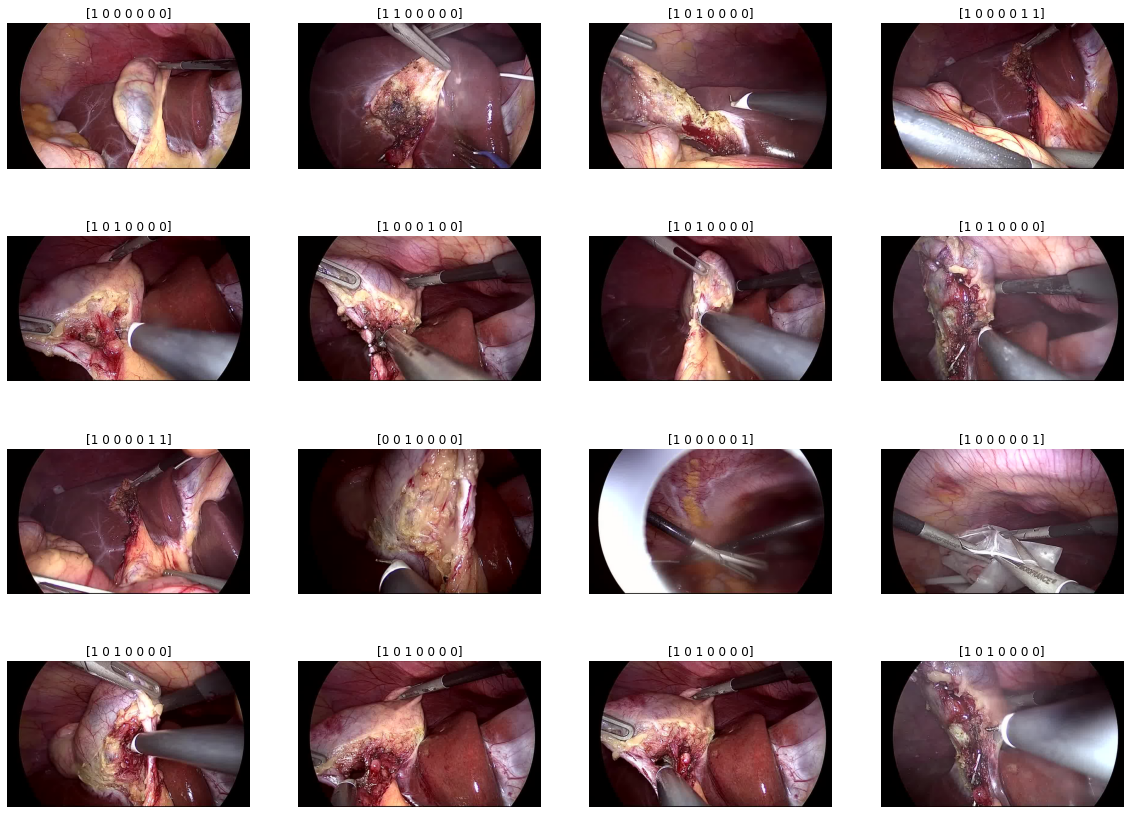

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_batch, label_batch = next(iter(trainset))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20, 15))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        plt.title(str(label_batch[n]))
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Experiment

### Keras model

In [ ]:
def make_model():
    base_model = tf.keras.applications.MobileNetV3Large(
        input_shape=(480, 800, 3), include_top=False, weights='imagenet'
    )

    # base_model.trainable = False
    # fine_tune_at = 14
    # for layer in base_model.layers[:fine_tune_at]:
    #     layer.trainable = False

    inputs = tf.keras.layers.Input([480, 800, 3])
    x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(50, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(7, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.BinaryAccuracy()]
    )

    return model

In [ ]:
# VGG16 trainable
model = make_model()
history = model.fit(
    dataset,
    epochs=50
)

Epoch 1/50
87/87 [==============================] - 84s 785ms/step - loss: 0.4851 - auc: 0.7383 - binary_accuracy: 0.7729
Epoch 2/50
87/87 [==============================] - 70s 785ms/step - loss: 0.3681 - auc: 0.8464 - binary_accuracy: 0.8446
Epoch 3/50
87/87 [==============================] - 70s 784ms/step - loss: 0.3008 - auc: 0.9006 - binary_accuracy: 0.8743
Epoch 4/50
87/87 [==============================] - 70s 784ms/step - loss: 0.2741 - auc: 0.9158 - binary_accuracy: 0.8865
Epoch 5/50
87/87 [==============================] - 70s 785ms/step - loss: 0.2386 - auc: 0.9362 - binary_accuracy: 0.9082
Epoch 6/50
87/87 [==============================] - 70s 784ms/step - loss: 0.2404 - auc: 0.9346 - binary_accuracy: 0.9028
Epoch 7/50
87/87 [==============================] - 70s 785ms/step - loss: 0.2052 - auc: 0.9530 - binary_accuracy: 0.9160
Epoch 8/50
87/87 [==============================] - 70s 784ms/step - loss: 0.2003 - auc: 0.9554 - binary_accuracy: 0.9200
Epoch 9/50
87/87 [======

In [ ]:
# InceptionV3
model = make_model()
history = model.fit(
    dataset,
    epochs=30,
    validation_data=testset
)

87916544/87910968 [==============================] - 0s 0us/step
Epoch 1/30
87/87 [==============================] - 65s 624ms/step - loss: 0.2979 - auc: 0.8992 - binary_accuracy: 0.8774 - val_loss: 0.2496 - val_auc: 0.9540 - val_binary_accuracy: 0.8960
Epoch 2/30
87/87 [==============================] - 52s 584ms/step - loss: 0.1636 - auc: 0.9705 - binary_accuracy: 0.9396 - val_loss: 0.0855 - val_auc: 0.9928 - val_binary_accuracy: 0.9723
Epoch 3/30
87/87 [==============================] - 52s 584ms/step - loss: 0.1324 - auc: 0.9828 - binary_accuracy: 0.9488 - val_loss: 0.0686 - val_auc: 0.9954 - val_binary_accuracy: 0.9773
Epoch 4/30
87/87 [==============================] - 52s 584ms/step - loss: 0.0989 - auc: 0.9905 - binary_accuracy: 0.9635 - val_loss: 0.0490 - val_auc: 0.9978 - val_binary_accuracy: 0.9843
Epoch 5/30
87/87 [==============================] - 52s 584ms/step - loss: 0.0892 - auc: 0.9921 - binary_accuracy: 0.9680 - val_loss: 0.0720 - val_auc: 0.9949 - val_binary_accurac

In [ ]:
# ResNet50
model = make_model()
history = model.fit(
    dataset,
    epochs=30,
    validation_data=testset
)

Epoch 1/30
87/87 [==============================] - 68s 699ms/step - loss: 0.2955 - auc: 0.8983 - binary_accuracy: 0.8744 - val_loss: 0.1172 - val_auc: 0.9865 - val_binary_accuracy: 0.9488
Epoch 2/30
87/87 [==============================] - 60s 679ms/step - loss: 0.1901 - auc: 0.9619 - binary_accuracy: 0.9260 - val_loss: 0.1155 - val_auc: 0.9744 - val_binary_accuracy: 0.9633
Epoch 3/30
87/87 [==============================] - 60s 678ms/step - loss: 0.1679 - auc: 0.9705 - binary_accuracy: 0.9319 - val_loss: 0.0684 - val_auc: 0.9951 - val_binary_accuracy: 0.9756
Epoch 4/30
87/87 [==============================] - 61s 678ms/step - loss: 0.1411 - auc: 0.9782 - binary_accuracy: 0.9442 - val_loss: 0.0603 - val_auc: 0.9946 - val_binary_accuracy: 0.9831
Epoch 5/30
87/87 [==============================] - 60s 678ms/step - loss: 0.1314 - auc: 0.9817 - binary_accuracy: 0.9472 - val_loss: 0.0627 - val_auc: 0.9974 - val_binary_accuracy: 0.9831
Epoch 6/30
87/87 [==============================] - 60s

In [ ]:
# Xception
model = make_model()
history = model.fit(
    dataset,
    epochs=30,
    validation_data=testset
)

Epoch 1/30
116/116 [==============================] - 175s 1s/step - loss: 0.4265 - auc: 0.8240 - binary_accuracy: 0.8072 - val_loss: 0.1652 - val_auc: 0.9819 - val_binary_accuracy: 0.9496
Epoch 2/30
116/116 [==============================] - 168s 1s/step - loss: 0.2579 - auc: 0.9301 - binary_accuracy: 0.8955 - val_loss: 0.1027 - val_auc: 0.9956 - val_binary_accuracy: 0.9769
Epoch 3/30
116/116 [==============================] - 167s 1s/step - loss: 0.1912 - auc: 0.9640 - binary_accuracy: 0.9276 - val_loss: 0.0638 - val_auc: 0.9957 - val_binary_accuracy: 0.9810
Epoch 4/30
116/116 [==============================] - 167s 1s/step - loss: 0.1537 - auc: 0.9776 - binary_accuracy: 0.9384 - val_loss: 0.0576 - val_auc: 0.9977 - val_binary_accuracy: 0.9789
Epoch 5/30
116/116 [==============================] - 168s 1s/step - loss: 0.1251 - auc: 0.9848 - binary_accuracy: 0.9554 - val_loss: 0.0560 - val_auc: 0.9978 - val_binary_accuracy: 0.9839
Epoch 6/30
116/116 [==============================] - 1

In [ ]:
# DenseNet
model = make_model()
history = model.fit(
    dataset,
    epochs=30,
    validation_data=testset
)

Epoch 1/30
174/174 [==============================] - 127s 598ms/step - loss: 0.3133 - auc: 0.9007 - binary_accuracy: 0.8690 - val_loss: 0.1481 - val_auc: 0.9819 - val_binary_accuracy: 0.9505
Epoch 2/30
174/174 [==============================] - 100s 568ms/step - loss: 0.1987 - auc: 0.9587 - binary_accuracy: 0.9274 - val_loss: 0.0730 - val_auc: 0.9970 - val_binary_accuracy: 0.9827
Epoch 3/30
174/174 [==============================] - 100s 566ms/step - loss: 0.1615 - auc: 0.9732 - binary_accuracy: 0.9398 - val_loss: 0.0558 - val_auc: 0.9976 - val_binary_accuracy: 0.9835
Epoch 4/30
174/174 [==============================] - 100s 566ms/step - loss: 0.1395 - auc: 0.9811 - binary_accuracy: 0.9476 - val_loss: 0.0427 - val_auc: 0.9981 - val_binary_accuracy: 0.9880
Epoch 5/30
174/174 [==============================] - 100s 566ms/step - loss: 0.1226 - auc: 0.9839 - binary_accuracy: 0.9535 - val_loss: 0.0466 - val_auc: 0.9982 - val_binary_accuracy: 0.9864
Epoch 6/30
174/174 [====================

In [ ]:
# EfficientNetB4
model = make_model()
history = model.fit(
    dataset,
    epochs=30,
    validation_data=testset
)

71688192/71686520 [==============================] - 1s 0us/step
Epoch 1/30
174/174 [==============================] - 222s 1s/step - loss: 0.3621 - auc: 0.8794 - binary_accuracy: 0.8523 - val_loss: 0.1477 - val_auc: 0.9849 - val_binary_accuracy: 0.9529
Epoch 2/30
174/174 [==============================] - 202s 1s/step - loss: 0.1976 - auc: 0.9586 - binary_accuracy: 0.9260 - val_loss: 0.0663 - val_auc: 0.9967 - val_binary_accuracy: 0.9810
Epoch 3/30
174/174 [==============================] - 203s 1s/step - loss: 0.1383 - auc: 0.9799 - binary_accuracy: 0.9515 - val_loss: 0.0508 - val_auc: 0.9975 - val_binary_accuracy: 0.9847
Epoch 4/30
174/174 [==============================] - 201s 1s/step - loss: 0.1193 - auc: 0.9852 - binary_accuracy: 0.9586 - val_loss: 0.0484 - val_auc: 0.9977 - val_binary_accuracy: 0.9839
Epoch 5/30
174/174 [==============================] - 202s 1s/step - loss: 0.0967 - auc: 0.9898 - binary_accuracy: 0.9672 - val_loss: 0.0365 - val_auc: 0.9987 - val_binary_accurac

In [ ]:
# MobileNetV3Large
model = make_model()
history = model.fit(
    dataset,
    epochs=30,
    validation_data=testset
)

17612800/17605208 [==============================] - 0s 0us/step
Epoch 1/30
174/174 [==============================] - 67s 340ms/step - loss: 0.3358 - auc: 0.8581 - binary_accuracy: 0.8571 - val_loss: 0.2616 - val_auc: 0.9121 - val_binary_accuracy: 0.9253
Epoch 2/30
174/174 [==============================] - 59s 330ms/step - loss: 0.2124 - auc: 0.9458 - binary_accuracy: 0.9164 - val_loss: 0.2128 - val_auc: 0.9521 - val_binary_accuracy: 0.9327
Epoch 3/30
174/174 [==============================] - 59s 331ms/step - loss: 0.1653 - auc: 0.9692 - binary_accuracy: 0.9316 - val_loss: 0.1432 - val_auc: 0.9684 - val_binary_accuracy: 0.9587
Epoch 4/30
174/174 [==============================] - 59s 330ms/step - loss: 0.1455 - auc: 0.9762 - binary_accuracy: 0.9409 - val_loss: 0.0939 - val_auc: 0.9841 - val_binary_accuracy: 0.9707
Epoch 5/30
174/174 [==============================] - 59s 330ms/step - loss: 0.1154 - auc: 0.9855 - binary_accuracy: 0.9562 - val_loss: 0.0902 - val_auc: 0.9855 - val_bina

### SHARPNESS-AWARE MINIMIZATION (SAM)
https://openreview.net/pdf?id=6Tm1mposlrM

In [19]:
def make_submodel():
    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=(480, 800, 3), include_top=False, weights='imagenet'
    )

    # base_model.trainable = False
    # fine_tune_at = 14
    # for layer in base_model.layers[:fine_tune_at]:
    #     layer.trainable = False

    inputs = tf.keras.layers.Input([480, 800, 3])
    x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(50, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(7, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # model.compile(
    #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    #     loss="binary_crossentropy",
    #     metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.BinaryAccuracy()]
    # )

    return model

In [20]:
class SAMModel(tf.keras.Model):
    def __init__(self, resnet_model, rho=0.05):
        """
        p, q = 2 for optimal results as suggested in the paper
        (Section 2)
        """
        super(SAMModel, self).__init__()
        self.resnet_model = resnet_model
        self.rho = rho

    def train_step(self, data):
        (images, labels) = data
        e_ws = []
        with tf.GradientTape() as tape:
            predictions = self.resnet_model(images)
            loss = self.compiled_loss(labels, predictions)
        trainable_params = self.resnet_model.trainable_variables
        gradients = tape.gradient(loss, trainable_params)
        grad_norm = self._grad_norm(gradients)
        scale = self.rho / (grad_norm + 1e-12)
        
        with tf.GradientTape() as tape:
            predictions = self.resnet_model(images)
            loss = self.compiled_loss(labels, predictions)    
        for (grad, param) in zip(gradients, trainable_params):
            e_w = grad * scale
            param.assign_add(e_w)
            e_ws.append(e_w)
        sam_gradients = tape.gradient(loss, trainable_params)
        for (param, e_w) in zip(trainable_params, e_ws):
            param.assign_sub(e_w)
        
        self.optimizer.apply_gradients(
            zip(sam_gradients, trainable_params))

        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        (images, labels) = data
        predictions = self.resnet_model(images, training=False)
        loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def call(self, images):
        return self.resnet_model(images)

    def _grad_norm(self, gradients):
        norm = tf.norm(
            tf.stack([
                tf.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm

In [ ]:
model = SAMModel(make_submodel())
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.BinaryAccuracy()]
)
history = model.fit(
    trainset,
    epochs=15,
    validation_data=testset
)

6701056/6698480 [==============================] - 0s 0us/step
Epoch 1/15
5320/5320 [==============================] - 4584s 856ms/step - loss: 0.0730 - auc: 0.9935 - binary_accuracy: 0.9730 - val_loss: 0.1262 - val_auc: 0.9832 - val_binary_accuracy: 0.9566
Epoch 2/15
5320/5320 [==============================] - 4531s 851ms/step - loss: 0.0459 - auc: 0.9971 - binary_accuracy: 0.9833 - val_loss: 0.0940 - val_auc: 0.9884 - val_binary_accuracy: 0.9676
Epoch 3/15
5320/5320 [==============================] - 4534s 852ms/step - loss: 0.0373 - auc: 0.9980 - binary_accuracy: 0.9863 - val_loss: 0.0977 - val_auc: 0.9867 - val_binary_accuracy: 0.9689
Epoch 4/15
5320/5320 [==============================] - 4530s 851ms/step - loss: 0.0316 - auc: 0.9985 - binary_accuracy: 0.9883 - val_loss: 0.1009 - val_auc: 0.9862 - val_binary_accuracy: 0.9701
Epoch 5/15
5320/5320 [==============================] - 4530s 851ms/step - loss: 0.0274 - auc: 0.9988 - binary_accuracy: 0.9900 - val_loss: 0.1010 - val_auc:

### Prediction

In [ ]:
import matplotlib.pyplot as plt

def show_batch_predictions(image_batch, label_batch):
    plt.figure(figsize=(30, 15))
    for n in range(9):
        ax = plt.subplot(3, 3, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        img_array = tf.expand_dims(image_batch[n], axis=0)
        plt.title("Predict " + str(model.predict(img_array)[0]) + "\nTrue " + str(label_batch[n].numpy()))
        plt.axis("off")


image_batch, label_batch = next(iter(testset))

show_batch_predictions(image_batch, label_batch)

In [ ]:
model.evaluate(testset)

190/190 [==============================] - 30s 147ms/step - loss: 0.1337 - auc: 0.9782 - binary_accuracy: 0.9716


[0.13374024629592896, 0.9782231450080872, 0.971555233001709]

In [ ]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(label_batch[3], a)
m.result().numpy()

0.85714287

In [ ]:
a

array([4.6393774e-02, 6.3514091e-02, 1.1410112e-02, 7.9290403e-05,
       2.2693494e-04, 2.1052957e-01, 7.2454088e-05], dtype=float32)

In [21]:
!nvidia-smi

Mon Aug  2 22:44:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    33W / 250W |    347MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------